In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.7 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [4]:
'''data1 = pd.read_csv("reddit_gpt3.csv")
data2 = pd.read_csv("reddit_instructgpt.csv")
data3 = pd.read_csv("reddit_human.csv")
data3["Generation"] = data3["Post Text"]
data = pd.concat([data1, data2, data3])'''

'data1 = pd.read_csv("reddit_gpt3.csv")\ndata2 = pd.read_csv("reddit_instructgpt.csv")\ndata3 = pd.read_csv("reddit_human.csv")\ndata3["Generation"] = data3["Post Text"]\ndata = pd.concat([data1, data2, data3])'

In [5]:
data = pd.read_csv("reddit.csv")

In [6]:
data["Generation"].isnull().unique()

array([False,  True])

In [7]:
data = data.dropna()

In [8]:
#data = data.drop(['Title', 'Post Text', 'Unnamed: 0', 'prompts'], axis = 1)

In [9]:
#data.to_csv("reddit.csv")

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
tokens = []
for text in data["Generation"]:
  tokens.append(tokenizer.tokenize(text))

In [12]:
token_ids = []
for token in tokens:
  token_ids.append(tokenizer.convert_tokens_to_ids(token))

In [13]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature = []
for corpus in data["Generation"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [14]:
maxlen = 100
padded_sequences = pad_sequences(token_ids, maxlen=maxlen)

In [15]:
feat = np.array(feature)

In [16]:
padd = np.concatenate([padded_sequences, feat], axis = 1)

In [17]:
labels = pd.get_dummies(data["label"]).values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, random_state=42)

In [19]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size + 8, 128, input_length=maxlen + 7))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))


# compile and train the model
batch_size = 64
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
17/17 [==============================] - 20s 350ms/step - loss: 0.9468 - accuracy: 0.5417 - val_loss: 1.0422 - val_accuracy: 0.6641
Epoch 2/30
17/17 [==============================] - 4s 252ms/step - loss: 0.5649 - accuracy: 0.7064 - val_loss: 0.9963 - val_accuracy: 0.7259
Epoch 3/30
17/17 [==============================] - 3s 167ms/step - loss: 0.3580 - accuracy: 0.8498 - val_loss: 0.9106 - val_accuracy: 0.7490
Epoch 4/30
17/17 [==============================] - 3s 197ms/step - loss: 0.1567 - accuracy: 0.9428 - val_loss: 0.8895 - val_accuracy: 0.7722
Epoch 5/30
17/17 [==============================] - 4s 209ms/step - loss: 0.1137 - accuracy: 0.9641 - val_loss: 0.8868 - val_accuracy: 0.7104
Epoch 6/30
17/17 [==============================] - 3s 165ms/step - loss: 0.0982 - accuracy: 0.9719 - val_loss: 0.8315 - val_accuracy: 0.6332
Epoch 7/30
17/17 [==============================] - 2s 132ms/step - loss: 0.0529 - accuracy: 0.9855 - val_loss: 0.7953 - val_accuracy: 0.6448
Epoch

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

11/11 [==============================] - 2s 20ms/step


In [21]:
y_test = np.argmax(y_test, axis=1)

In [22]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       123
           1       0.97      0.90      0.93        99
           2       0.66      0.69      0.68       101

    accuracy                           0.78       323
   macro avg       0.79      0.78      0.79       323
weighted avg       0.79      0.78      0.78       323

[[93  3 27]
 [ 1 89  9]
 [31  0 70]]


In [23]:
from sklearn.metrics import f1_score

In [24]:
f1_macro = f1_score(y_test, y_pred, average="macro")

print("F1 macro score:", f1_macro)

F1 macro score: 0.7860885583967759


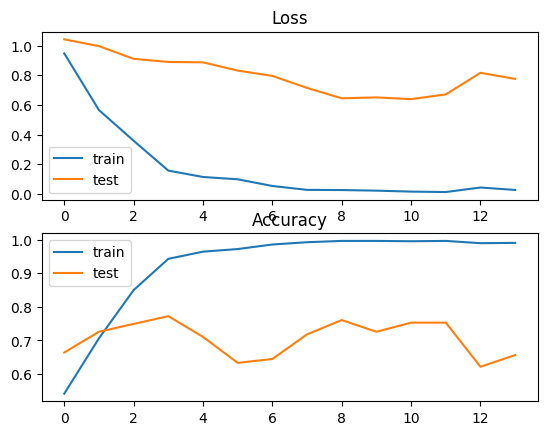

In [25]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()